## Exploring data

Firstly, we will need to carefully study the dataset that will be used to solve the classification problem. To do this, we will load the necessary libraries, and import data structures and functions which will be particularly useful in training machine learning models. Additionally, let's define sizes (shares) of training, validation and test sets so that we would be able to set them beforehand.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Setting and verifying set sizes
TRAIN_SET_SIZE = 0.6
VALID_SET_SIZE = 0.2
TEST_SET_SIZE = 0.2
assert (
    np.round(np.sum([TRAIN_SET_SIZE, VALID_SET_SIZE, TEST_SET_SIZE]), 2) == 1.0
), "Incorrect proportions"

# Setting a visual theme for plots
sns.set_theme(style="darkgrid")

Now, after getting access to `pandas` library for data analysis, we will use the `read_csv()` function to read the dataset and save it as a DataFrame.

In [2]:
users_data = pd.read_csv("users_behavior.csv")

Let's display random ten rows of the DataFrame contained in `users_data` variable and consider the information shown.

In [3]:
users_data.sample(10)

,calls,minutes,messages,mb_used,is_ultra
1294,40.0,280.44,2.0,13934.54,0
542,107.0,729.44,153.0,32990.68,1
550,100.0,693.21,49.0,5451.26,1
2921,42.0,247.60,50.0,15239.37,0
1184,4.0,17.78,11.0,11067.06,0
844,160.0,1055.79,54.0,33629.53,1
3064,78.0,553.56,0.0,14544.55,0
3188,78.0,514.37,42.0,16543.09,1
1015,42.0,319.80,121.0,16790.96,0
2507,36.0,260.94,10.0,15438.40,0


We can see that the data seems to be already preprocessed, where we have 4 features expressed by `calls`, `minutes`, `messages` and `mb_used` columns as well as one binary target variable - `is_ultra`. In this case, we will solve the binary classification problem with two classes so at first sight the target is seen to be encoded correctly. Nevertheless, let's take a closer look at the DataFrame and output a concise summary of it using the `info()` method.

In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


We observe the following. The table contains data on 3,214 customers of a mobile operator that are characterized by five columns: four features and one target. The features are numeric and have `float64` data type, while the target variable is binary and is therefore expressed by the integer type - `int64`. The number of non-null values are equal across DataFrame columns and are equal to the total number of objects in the dataset, which indicates the absence of missing values. Let's take a closer look at what information the columns contain:

* `calls` - number of calls;
* `minutes` - total duration of calls (minutes);
* `messages` - number of SMS messages;
* `mb_used` - internet traffic used (MB);
* `is_ultra` - indicator of the customer's tariff (1 -> "Ultra", 0 -> "Smart").

It seems that data preprocessing will not be required: there are no missing values in this dataset. However, it is worth converting data types in the `calls` and `messages` columns, since the numbers of calls and SMS messages cannot be fractional. This will not affect the results of the study but, nevertheless, the features should be characterized by correct data types.

In [5]:
# Conversion to int64
users_data["calls"] = users_data["calls"].astype("int64")
users_data["messages"] = users_data["messages"].astype("int64")

Now, let's look at the first five rows of the DataFrame and print a summary of it in order to check whether the changes made were actually carried out.

In [6]:
users_data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


In [7]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [8]:
# Verifying the absence of missing values
num_nans = users_data.isnull().sum()
assert num_nans.sum() == 0, f"{num_nans.sum()} missing values unprocessed"

It can be seen that the data has been properly tranformed and can be used in the machine learning process. Before proceeding to dividing the dataset into sets, let's look at the distribution of values in each feature column and how they are scattered relative to one another, depending on tariff.

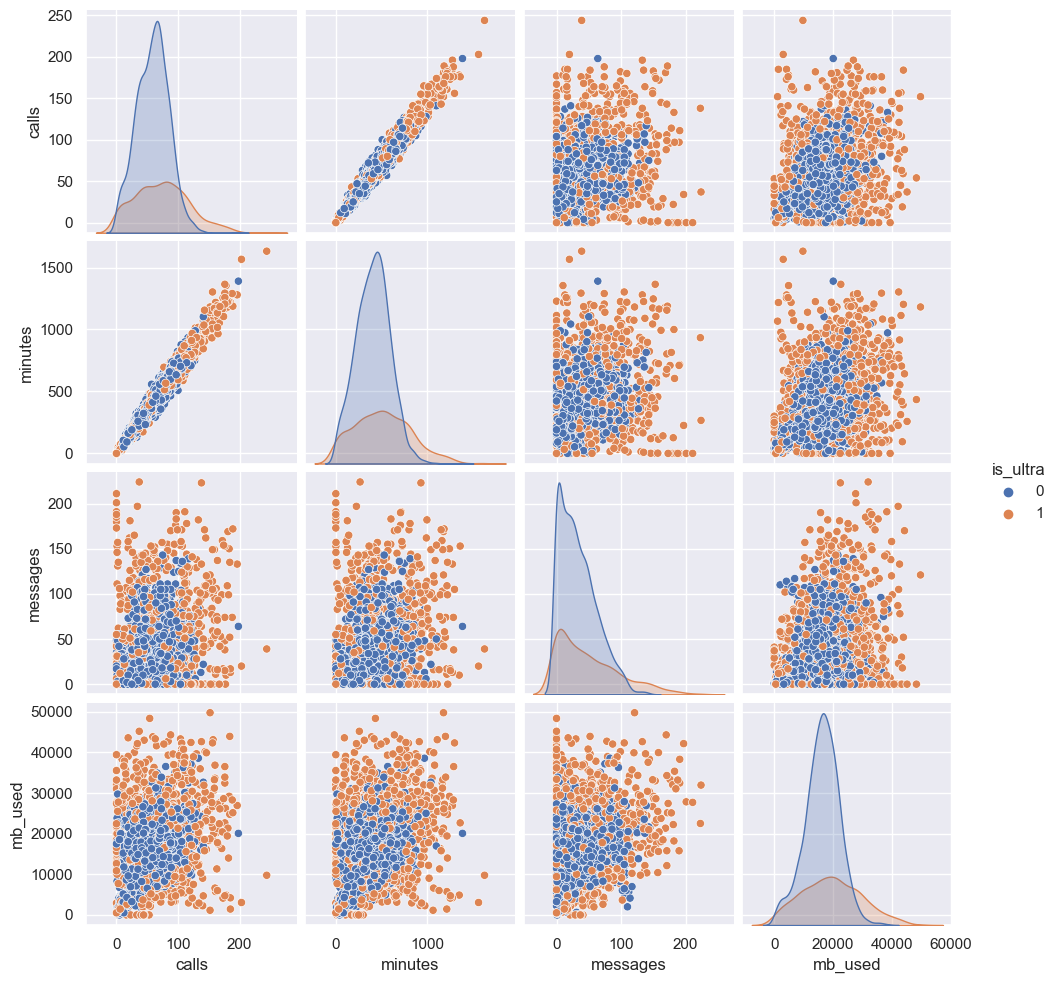

In [9]:
# Plotting histograms and scatterplots for features
sns.pairplot(data=users_data, hue="is_ultra")
plt.show()

Finally, we can plot the numeric structure of the target variable.

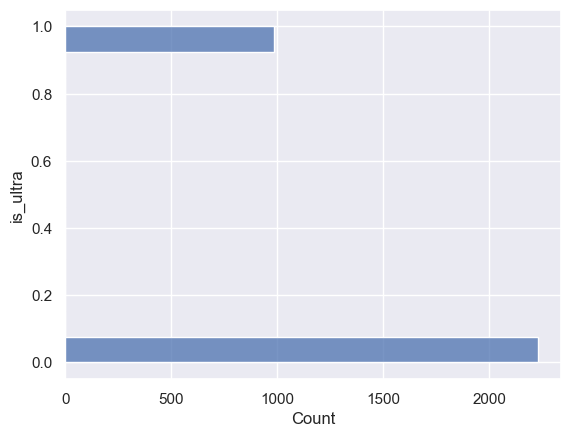

In [10]:
# Plotting a histogram for a target
sns.histplot(data=users_data, y="is_ultra")
plt.show()

We see that the distribution of features resembles a normal distribution but a rightly skewed one, with the `messages` column being the most vivid example. As far as the target variable is concerned, we see that the classes are imbalanced: the dataset contains more clients with "Smart" tariff rather than with "Ultra".

**Conclusion**

At this preliminary stage, the data has been studied and visualized. The data has already been prepared for this study but, nevertheless, the data types in the `calls` and `messages` columns have been converted to integer for more correct data display.

## Training, validation and test sets

The data is ready for machine learning. Before dividing the data into data sets, we will need to separate the features from the target variable and save them into separate variables.

In [11]:
# Separating features from target
features = users_data.drop(["is_ultra"], axis=1)
target = users_data["is_ultra"]

Now, it is necessary to divide the data into training, validation and test sets. The test set will not be hidden from us so we will make use of the following proportions:

* Training set (60%)
* Validation set (20%)
* Test set (20%)

In order to split the data in this way, we can use the `train_test_split()` function from the `model_selection` module of the `sklearn` library. Since this function can split the data only once per call, first we divide the data into training and validation/test sets in 60-40 proportion and then by calling `train_test_split()` function the second time, we split the combination of validation and test sets equally, thus achieving proportions of 20-20. Hence, we define such cutoffs as `split_1` and `split_2` that will be used to split the data accordingly depending on set sizes. 

In [12]:
# Defining cutoffs for splits
split_1 = 1 - TRAIN_SET_SIZE
split_2 = TEST_SET_SIZE / np.sum([VALID_SET_SIZE, TEST_SET_SIZE])

# Dividing data into a training set and a validation/test set
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=split_1, random_state=12345
)

# Separating validation and test sets
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=split_2, random_state=12345
)

Now, let's verify whether we have managed to correctly divide DataFrame into data sets and whether we have preserved the correct proportions.

In [13]:
# Aggregating information about sets
df_columns = {
    "set_size": [
        features_train.shape[0],
        features_valid.shape[0],
        features_test.shape[0],
    ],
    "set_share": [
        features_train.shape[0] / features.shape[0],
        features_valid.shape[0] / features.shape[0],
        features_test.shape[0] / features.shape[0],
    ],
}
sets_info = pd.DataFrame(
    data=df_columns, index=["Training set", "Validation set", "Test set"]
)

assert (np.sum(sets_info["set_size"]) == features.shape[0]) & (
    np.sum(sets_info["set_share"]) == 1.0
), "Incorrect proportions"

sets_info.style.format({"set_share": "{:.2f}".format})

,set_size,set_share
Training set,1928,0.60
Validation set,643,0.20
Test set,643,0.20


We can see that the sum of the number of objects in the training, validation and test sets coincides with the total number of objects in the total DataFrame. Moreover, we were able to preserve the required proportions when splitting the data.

**Conclusion**

This intermediate stage allowed for the final preparation of data for their use in classification algorithms. The DataFrame has been divided into training, validation and test test in the proportion of 60-20-20. Moreover, the correctness of the data splitting was checked manually, which enables moving on to training machine learning models.

## Training models

Consider three classification models:

* *Decision Tree* => `DecisionTreeClassifier`
* *Random Forest* => `RandomForestClassifier`
* *Logistic Regression* => `LogisticRegression`

We will adhere to the following strategy. We will conduct hyperparameter tuning for each of the above models and find the optimal combination of hyperparameters that will lead to a high *accuracy* value for each of the three models. In other words, we will separately consider each model, determine which values for which hyperparameters we will vary, and calculate *accuracy* for such patricular settings of a particular model based on a validation set. Next, after conducting optimal hyperparameters values search and selecting the three best-performing models in terms of *accuracy*, we will compare them and choose the best one.

### Decision Tree

Let's start with the Decision Tree and tune the hyperparameter of the maximum depth of the Tree - `max_depth`, where we will consider values from 1 to 10. At the same time, we will display the entire process of a hyperparameter selection on the screen in order to control the tuning process and determine whether the model is overfitting or underfitting for each variation of the hyperparameter. In other words, we will calculate the values of *accuracy* for each variant of the hyperparameter for both training and validation sets. Since a high *accuracy* obtained in the training set may indicate overfitting and by no means a high generalization power of the trained model, where the model simply memorized all the answers, we will decide on the best model based on a high value of *accuracy* on the validation test, that is, on a data set that the model has not seen during training.

In [14]:
# Hyperparameter tuning (Decision Tree) -> {'max_depth'}
best_model_DTC = None
best_result_DTC = 0
print("-" * 65)
print("Hyperparameter tuning of max_depth (DecisionTreeClassifier)")
print("-" * 65)
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    # Computing predictions for training and validation sets
    predictions_train = model.predict(features_train)
    predictions_valid = model.predict(features_valid)
    # Computing accuracy for training and validation sets
    accuracy_train = accuracy_score(target_train, predictions_train)
    accuracy_valid = accuracy_score(target_valid, predictions_valid)
    # Making a decision about the best model
    if accuracy_valid > best_result_DTC:
        best_model_DTC = model
        best_result_DTC = accuracy_valid
    print(
        f"max_depth = {depth} : accuracy_train = {accuracy_train:.4f}, accuracy_valid = {accuracy_valid:.4f}"
    )
print("-" * 65)
print(f"\nBest model (validation set): {best_model_DTC}")
print(f"Best accuracy (validation set): {best_result_DTC:.4f}")

-----------------------------------------------------------------
Hyperparameter tuning of max_depth (DecisionTreeClassifier)
-----------------------------------------------------------------
max_depth = 1 : accuracy_train = 0.7578, accuracy_valid = 0.7543
max_depth = 2 : accuracy_train = 0.7879, accuracy_valid = 0.7823
max_depth = 3 : accuracy_train = 0.8076, accuracy_valid = 0.7854
max_depth = 4 : accuracy_train = 0.8107, accuracy_valid = 0.7792
max_depth = 5 : accuracy_train = 0.8200, accuracy_valid = 0.7792
max_depth = 6 : accuracy_train = 0.8377, accuracy_valid = 0.7838
max_depth = 7 : accuracy_train = 0.8558, accuracy_valid = 0.7823
max_depth = 8 : accuracy_train = 0.8626, accuracy_valid = 0.7792
max_depth = 9 : accuracy_train = 0.8812, accuracy_valid = 0.7823
max_depth = 10 : accuracy_train = 0.8890, accuracy_valid = 0.7745
-----------------------------------------------------------------

Best model (validation set): DecisionTreeClassifier(max_depth=3, random_state=12345)
Best 

The results of training the Decision Tree model show that as the depth of the Tree increases, *accuracy* grows on the training set and on the validation set it fluctuates around 0.77-0.78 which indicates that the model has been overfitting for higher values of `max_depth`. Nevertheless, as the results show, the Decision Tree is less prone to overfitting for a small Tree depth: the hyperparameter tuning determined `max_depth=3` as the best depth for which the quality of 78.5% is achieved, which is the best in this experiment.

### Random Forest

Let's carry out a similar process of selecting hyperparameters for a Random Forest. Only this time, in addition to considering the values of the depth of Trees `max_depth` from 1 to 10, we will also consider the number of trees `n_estimators` that should comprise the Forest (from 10 to 50 trees with increments of 10).

In [15]:
# Hyperparameter tuning (Random Forest) -> {'n_estimators', 'max_depth'}
best_model_RFC = None
best_result_RFC = 0
print("-" * 85)
print("Hyperparameter tuning of n_estimators, max_depth (RandomForestClassifier)")
print("-" * 85)
for est in range(10, 51, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(
            random_state=12345, n_estimators=est, max_depth=depth
        )
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train)
        predictions_valid = model.predict(features_valid)
        accuracy_train = accuracy_score(target_train, predictions_train)
        accuracy_valid = accuracy_score(target_valid, predictions_valid)
        if accuracy_valid > best_result_RFC:
            best_model_RFC = model
            best_result_RFC = accuracy_valid
        print(
            f"n_estimators = {est}, max_depth = {depth} : accuracy_train = {accuracy_train:.4f}, accuracy_valid = {accuracy_valid:.4f}"
        )
    print("-" * 85)
print(f"\nBest model (validation set): {best_model_RFC}")
print(f"Best accuracy (validation set): {best_result_RFC:.4f}")

-------------------------------------------------------------------------------------
Hyperparameter tuning of n_estimators, max_depth (RandomForestClassifier)
-------------------------------------------------------------------------------------
n_estimators = 10, max_depth = 1 : accuracy_train = 0.7443, accuracy_valid = 0.7558
n_estimators = 10, max_depth = 2 : accuracy_train = 0.7785, accuracy_valid = 0.7776
n_estimators = 10, max_depth = 3 : accuracy_train = 0.8102, accuracy_valid = 0.7854
n_estimators = 10, max_depth = 4 : accuracy_train = 0.8143, accuracy_valid = 0.7900
n_estimators = 10, max_depth = 5 : accuracy_train = 0.8242, accuracy_valid = 0.7932
n_estimators = 10, max_depth = 6 : accuracy_train = 0.8351, accuracy_valid = 0.8009
n_estimators = 10, max_depth = 7 : accuracy_train = 0.8553, accuracy_valid = 0.7947
n_estimators = 10, max_depth = 8 : accuracy_train = 0.8698, accuracy_valid = 0.7963
n_estimators = 10, max_depth = 9 : accuracy_train = 0.8729, accuracy_valid = 0.785

The best accuracy was achieved for a Random Forest that includes 40 trees with a depth of 8. The value of this metric turned out to be better than that of a Decision Tree, since in this case not one tree is used, but a whole ensemble.

### Logistic Regression

There are not so many hyperparameters in this model that it would be interesting to vary, but we can consider the `C` hyperparameter responsible for regularization. According to the documentation of *scikit-learn*, the values of this hyperparameter must be positive and have the `float` type. Let's consider different values for this hyperparameter, where we will decrease the strength of regularization as the values of `C` increase. In addition, for all iterations, we will fix the maximum number of iterations of the model at `max_iter=1000` and use the optimization algorithm `solver="lbfgs"`.

In [16]:
# Hyperparameter tuning (Logistic Regression) -> {'C'}
best_model_log = None
best_result_log = 0
print("-" * 64)
print("Hyperparameter tuning of C (LogisticRegression)")
print("-" * 64)
for c in [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]:
    model = LogisticRegression(random_state=12345, solver="lbfgs", max_iter=1000, C=c)
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train)
    predictions_valid = model.predict(features_valid)
    accuracy_train = accuracy_score(target_train, predictions_train)
    accuracy_valid = accuracy_score(target_valid, predictions_valid)
    if accuracy_valid > best_result_log:
        best_model_log = model
        best_result_log = accuracy_valid
    print(
        f"C = {c} : accuracy_train = {accuracy_train:.4f}, accuracy_valid = {accuracy_valid:.4f}"
    )
print("-" * 64)
print(f"\nBest model (validation set): {best_model_log}")
print(f"Best accuracy (validation set): {best_result_log:.4f}")

----------------------------------------------------------------
Hyperparameter tuning of C (LogisticRegression)
----------------------------------------------------------------
C = 1.0 : accuracy_train = 0.7132, accuracy_valid = 0.7107
C = 3.0 : accuracy_train = 0.7132, accuracy_valid = 0.7107
C = 10.0 : accuracy_train = 0.7531, accuracy_valid = 0.7558
C = 30.0 : accuracy_train = 0.7531, accuracy_valid = 0.7558
C = 100.0 : accuracy_train = 0.7531, accuracy_valid = 0.7558
C = 300.0 : accuracy_train = 0.7531, accuracy_valid = 0.7558
C = 1000.0 : accuracy_train = 0.7531, accuracy_valid = 0.7558
C = 3000.0 : accuracy_train = 0.7531, accuracy_valid = 0.7558
C = 10000.0 : accuracy_train = 0.7531, accuracy_valid = 0.7558
----------------------------------------------------------------

Best model (validation set): LogisticRegression(C=10.0, max_iter=1000, random_state=12345)
Best accuracy (validation set): 0.7558


We can see that after reaching the value `C=10.0`, the values of the metric in the validation and training sets stopped changing and converged to *accuracy* of 0.7558. It is noticeable that the degree of overfitting of the model is extremely small (*accuracy* on the training and validation samples are quite close to each other), since the model does not have many parameters and is relatively simple. Hence, we can say that for the best specification of the Logistic Regression model, the strength of regularization is not so substantial.

### Model selection

Now let's summarize the obtained results of training models and choose the best model out of three.

In [17]:
# Creating a DataFrame with results
cols = {
    "model": [
        type(best_model_DTC).__name__,
        type(best_model_RFC).__name__,
        type(best_model_log).__name__,
    ],
    "accuracy_score_valid": [best_result_DTC, best_result_RFC, best_result_log],
}
df = pd.DataFrame(data=cols)

# Creating a rating
df_compare = (
    df.sort_values(by="accuracy_score_valid", ascending=False)
    .round(4)
    .reset_index(drop=True)
    .set_index(pd.Series([1, 2, 3]))
)

display(df_compare)

# Determining the final model
if df_compare.model[1] == type(best_model_DTC).__name__:
    best_model_final = best_model_DTC
elif df_compare.model[1] == type(best_model_RFC).__name__:
    best_model_final = best_model_RFC
else:
    best_model_final = best_model_log

print(f"Final model (validation set): {best_model_final}")
print(f"Accuracy (validation set): {df_compare.accuracy_score_valid[1]}")

,model,accuracy_score_valid
1,RandomForestClassifier,0.8087
2,DecisionTreeClassifier,0.7854
3,LogisticRegression,0.7558


Final model (validation set): RandomForestClassifier(max_depth=8, n_estimators=40, random_state=12345)
Accuracy (validation set): 0.8087


We see that the best model that has achieved the best value of the *accuracy* metric is a Random Forest.

**Conclusion**

We have managed to train three machine learning models (Decision Tree, Random Forest and Logistic Regression), where we have carried out hyperparameters tuning for each of them. Based on the highest value of the *accuracy* criterion in the validation set, we determined three optimal variants of these models with certain settings. Afterwards, after comparing these three optimal models, we chose a Random Forest model with 40 trees and a depth of 8 as the model that outperforms other models in terms of correctly predicting (recommending) the tariff for users.

## Testing the final model

Now, let's take the model of Random Forest that we have selected and look at its performance on the test set.

In [18]:
# Testing the final model
best_model_final.fit(features_train, target_train)
predictions_test = best_model_final.predict(features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
print(f"Final model (test set): {best_model_final}")
print(f"Accuracy (test set): {accuracy_test:.4f}")

Final model (test set): RandomForestClassifier(max_depth=8, n_estimators=40, random_state=12345)
Accuracy (test set): 0.7963


The quality of the model turned out to be quite close to *accuracy* on the validation dataset and is approximately 79.6%.

**Conclusion**

At this stage, we used the final model (Random Forest) to test the trained model on a new dataset. The quality turned out to be 0.7963, which is higher than the set level of 0.75.

## Sanity check

We will check the adequacy of the final model of a Random Forest on a test sample. To conduct such an experiment, we must compare the quality of our final model with a static one, that is, a model that will always predict the same class. In this way, we will be able to determine whether the Random Forest model we trained is sane and whether its predictions differ greatly from the predictions made by the static model. In this case, in the classification problem, as static predictions we can use a model that recommends the most frequent class in the training set, that is, in this case, the "Smart" tariff (class 0). We can do this by using the `DummyClassifier` from the `dummy` module of the `sklearn` library.

In [19]:
class ModelSanityError(Exception):
    """Exception to be raised in case of
    the model proving to be inadequate.
    """

    pass

In [20]:
# Sanity check
dmb = DummyClassifier(random_state=12345, strategy="most_frequent")
dmb.fit(features_train, target_train)
dmb_score = dmb.score(features_test, target_test)
if accuracy_test > dmb_score:
    print("Model is adequate\n")
    print(f"Final model (test set): {best_model_final}")
    print(f"Accuracy (final model): {accuracy_test:.4f}\n")
    print(f"Static model (test set): {dmb}")
    print(f"Accuracy (test set): {dmb_score:.4f}")
else:
    raise ModelSanityError("Model is inadequate")

Model is adequate

Final model (test set): RandomForestClassifier(max_depth=8, n_estimators=40, random_state=12345)
Accuracy (final model): 0.7963

Static model (test set): DummyClassifier(random_state=12345, strategy='most_frequent')
Accuracy (test set): 0.6843


Using `DummyClassifier`, we generated predictions consisting entirely of zeros, that is, as mentioned above, the random model will always recommend the "Smart" tariff to the client (0 is the most common value in the training set for the target variable). The accuracy turned out to be quite close to 0.7, but our model on the test set shows the value of the quality metric greater than 0.75 so our trained model is sane.

**Conclusion**

The use of static predictions led to an underestimation of the quality indicator, which indicates the sanity of the model trained above.

## General conclusion

Within the framework of this study, the data of customers of a mobile operator were analyzed and an optimal system of tariff recommendation was developed. In particular, data were prepared for three classifiers (Decision Tree, Random Forest and Logistic Regression), and hyperparameters were selected. As a result, the best model from the point of view of the quality metric *accuracy* is a Random Forest with 40 trees with a depth of 8, which correctly predicts tariffs in about 79.6% of cases, which is higher than the benchmark level of 75%. Additionally, a sanity check was carried out for the final model of Random Forest, where we generated static predictions of recommending the most frequent tariff and compared them with the quality of Random Forest. It has been shown that trained model is much better at predicting tariffs than a static model, which shows the adequacy of the final model selected.